# Analisando o bot

Este jupyter-notebook vai auxiliar na análise de um RASA bot.

## Instalação

### Configurando jupyter

In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Instalação do Rasa


In [ ]:
import sys
python = sys.executable

# In your environment run:
#!{python} -m pip install -U rasa_core==0.9.0a7 rasa_nlu[spacy];
!{python} -m pip install -U rasa_core==0.9.0a7 rasa_nlu[spacy]==0.12.3;

# as well as install a language model:
!{python} -m spacy download pt;

    100% |████████████████████████████████| 122kB 787kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/e7/24/9dacfae4525ea885c1d908878296ad705512eb6f72a95a51fbd728ea6fa8/rasa_nlu-0.12.3-py2.py3-none-any.whl
    100% |████████████████████████████████| 931kB 1.3MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/f1/51/d1bd383522c12b313eddd7b97b8e7d6cd2a8e3b44b8ff3c88e4a7b045cc8/python_telegram_bot-10.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3b/f6/7a76333cf0b9251ecf49efff635015171843d9b977e4ffcf59f9c4428052/redis-2.10.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/93/70/203660597d12788e958dd691aa11c3c29caa075eadb2ce94d2eb53099d1b/mattermostwrapper-2.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 245kB 1.5MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/0e/e1/50dbc513aa74e99eca4c47f2a8206711f0bec436fdddd95eebaf7eaaa1aa/colorhash-1.0.2-py2.p

Verificando versões:

In [3]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("pt")("Olá Mundo!"))

rasa_nlu: 0.12.3 rasa_core: 0.9.0a7
Loading spaCy language model...
Olá Mundo!


### Ferramentas adicionais

Atualize a instalação de acordo com seu sistema operacional

In [4]:
#!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
#!brew install graphviz;

In [5]:
#!{python} -m pip install pygraphviz;

### NLU Pipeline

Criando um pipeline de nlu para o bot.

`Caso queira testar diferentes algoritmos/modelos dentro do RASA nlu, mude a celula seguinte.`

In [6]:
config = """
language: "pt"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_spacy"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


## Adicionando nlu (natural language understanding)

Nesta parte o bot vai aprender a entender a linguagem

### Treinando o modelo do Rasa NLU

In [7]:
import os

from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config


intents_directory = 'intents/'

intents = {}

for intent_file in os.listdir(intents_directory):
    intent_file_path = os.path.join(intents_directory, intent_file)

    intents[intent_file] = {}

    intent_list = []
    intent_name = None

    with open(intent_file_path) as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip()

            if line.startswith('##'):
                if intent_name is not None:
                    intents[intent_file][intent_name] = intent_list
                intent_name = line.replace('## intent:', '') 
                intent_list = []

            elif line.startswith('- '):
                intent_list.append(line.replace('- ', ''))


# loading the nlu training samples
training_data = load_data(intents_directory)

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of intents/geral.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 220 (7 distinct intents)
	- Found intents: 'afirmar_curiosidades', 'o_que_eh', 'extra', 'afirmar', 'negar', 'afirmar_projeto', 'cumprimentar'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.training_data.loading:Training data format of intents/curiosidades.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 153 (8 distinct intents)
	- Found intents: 'curiosidades_receber_incetivo_de_parentes', 'curiosidades_beneficios_incentivo_projetos_culturais', 'curiosidades_quantidade_projetos', 'curiosidades_elegibilidade_de_empresa_para_beneficios', 'curiosidades_deducao_imposto_de_renda_incentivador', 'curiosidades_lei_rouanet_denuncia', 'curiosidades_lei_rouanet_arrecadamento', 'curiosidades_lei_rouanet_elegibilidade'
	- entity examples: 0 (0 distinct entitie

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.2s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into '/home/arthur/Documents/lappis/bot/rasa-demo-pydata18/tais/models/nlu/default/current'


### Avaliação do modelo de NLU treinado

`Caso queira testar mensagens específicas mande a mensagem na célula seguinte`

In [8]:
pprint(interpreter.parse("sim"))

{
  "intent": {
    "name": "afirmar",
    "confidence": 0.5657123459805232
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "afirmar",
      "confidence": 0.5657123459805232
    },
    {
      "name": "extra",
      "confidence": 0.21091467426564922
    },
    {
      "name": "cumprimentar",
      "confidence": 0.1027579652477443
    },
    {
      "name": "negar",
      "confidence": 0.09597541581832517
    },
    {
      "name": "afirmar_curiosidades",
      "confidence": 0.004568532250882414
    },
    {
      "name": "curiosidades_lei_rouanet_elegibilidade",
      "confidence": 0.0038236504456690768
    },
    {
      "name": "curiosidades_lei_rouanet_denuncia",
      "confidence": 0.0030125461553329002
    },
    {
      "name": "afirmar_projeto",
      "confidence": 0.002476849526777554
    },
    {
      "name": "o_que_eh",
      "confidence": 0.0022008703652476795
    },
    {
      "name": "curiosidades_lei_rouanet_arrecadamento",
      "confidence": 0.0018439

### Avaliação de correlação das intents

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-pt'.
INFO:rasa_nlu.training_data.loading:Training data format of ./intents/curiosidades.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 153 (8 distinct intents)
	- Found intents: 'curiosidades_receber_incetivo_de_parentes', 'curiosidades_beneficios_incentivo_projetos_culturais', 'curiosidades_quantidade_projetos', 'curiosidades_elegibilidade_de_empresa_para_beneficios', 'curiosidades_deducao_imposto_de_renda_incentivador', 'curiosidades_lei_rouanet_denuncia', 'curiosidades_lei_rouanet_arrecadamento', 'curiosidades_lei_rouanet_elegibilidade'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 153 examples that have a defined intent out of 153 examples
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.

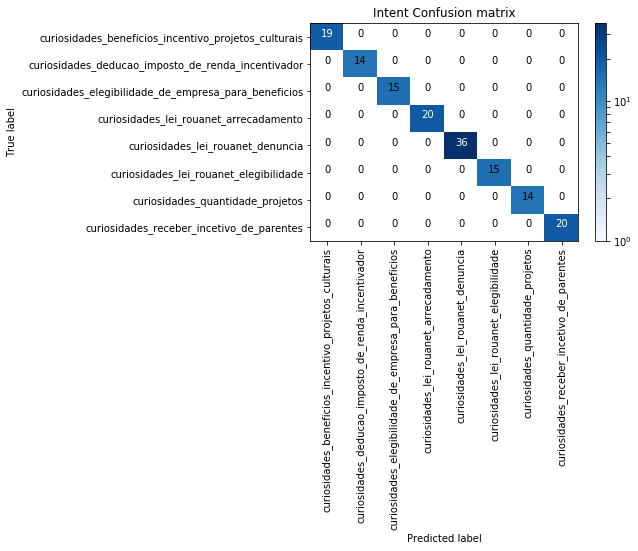

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_spacy 
INFO:rasa_nlu.evaluate:F1-Score:  0.9930615784908934
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  0.9862187769164513
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

        LOC       0.00      0.00      0.00         0
       MISC       0.00      0.00      0.00         0
        ORG       0.00      0.00      0.00         0
        PER       0.00      0.00      0.00         0
  no_entity       1.00      0.99      0.99      1161

avg / total       1.00      0.99      0.99      1161



In [20]:
from rasa_nlu.evaluate import run_evaluation
run_evaluation('./intents/curiosidades.md', model_directory)

# RASA core

`Adicionando stories`

### Definindo Contexto (domain)

### Visualização do fluxo de conversa

INFO:apscheduler.scheduler:Scheduler started
Processed Story Blocks: 100%|██████████| 32/32 [00:00<00:00, 76.83it/s, # trackers=522] 


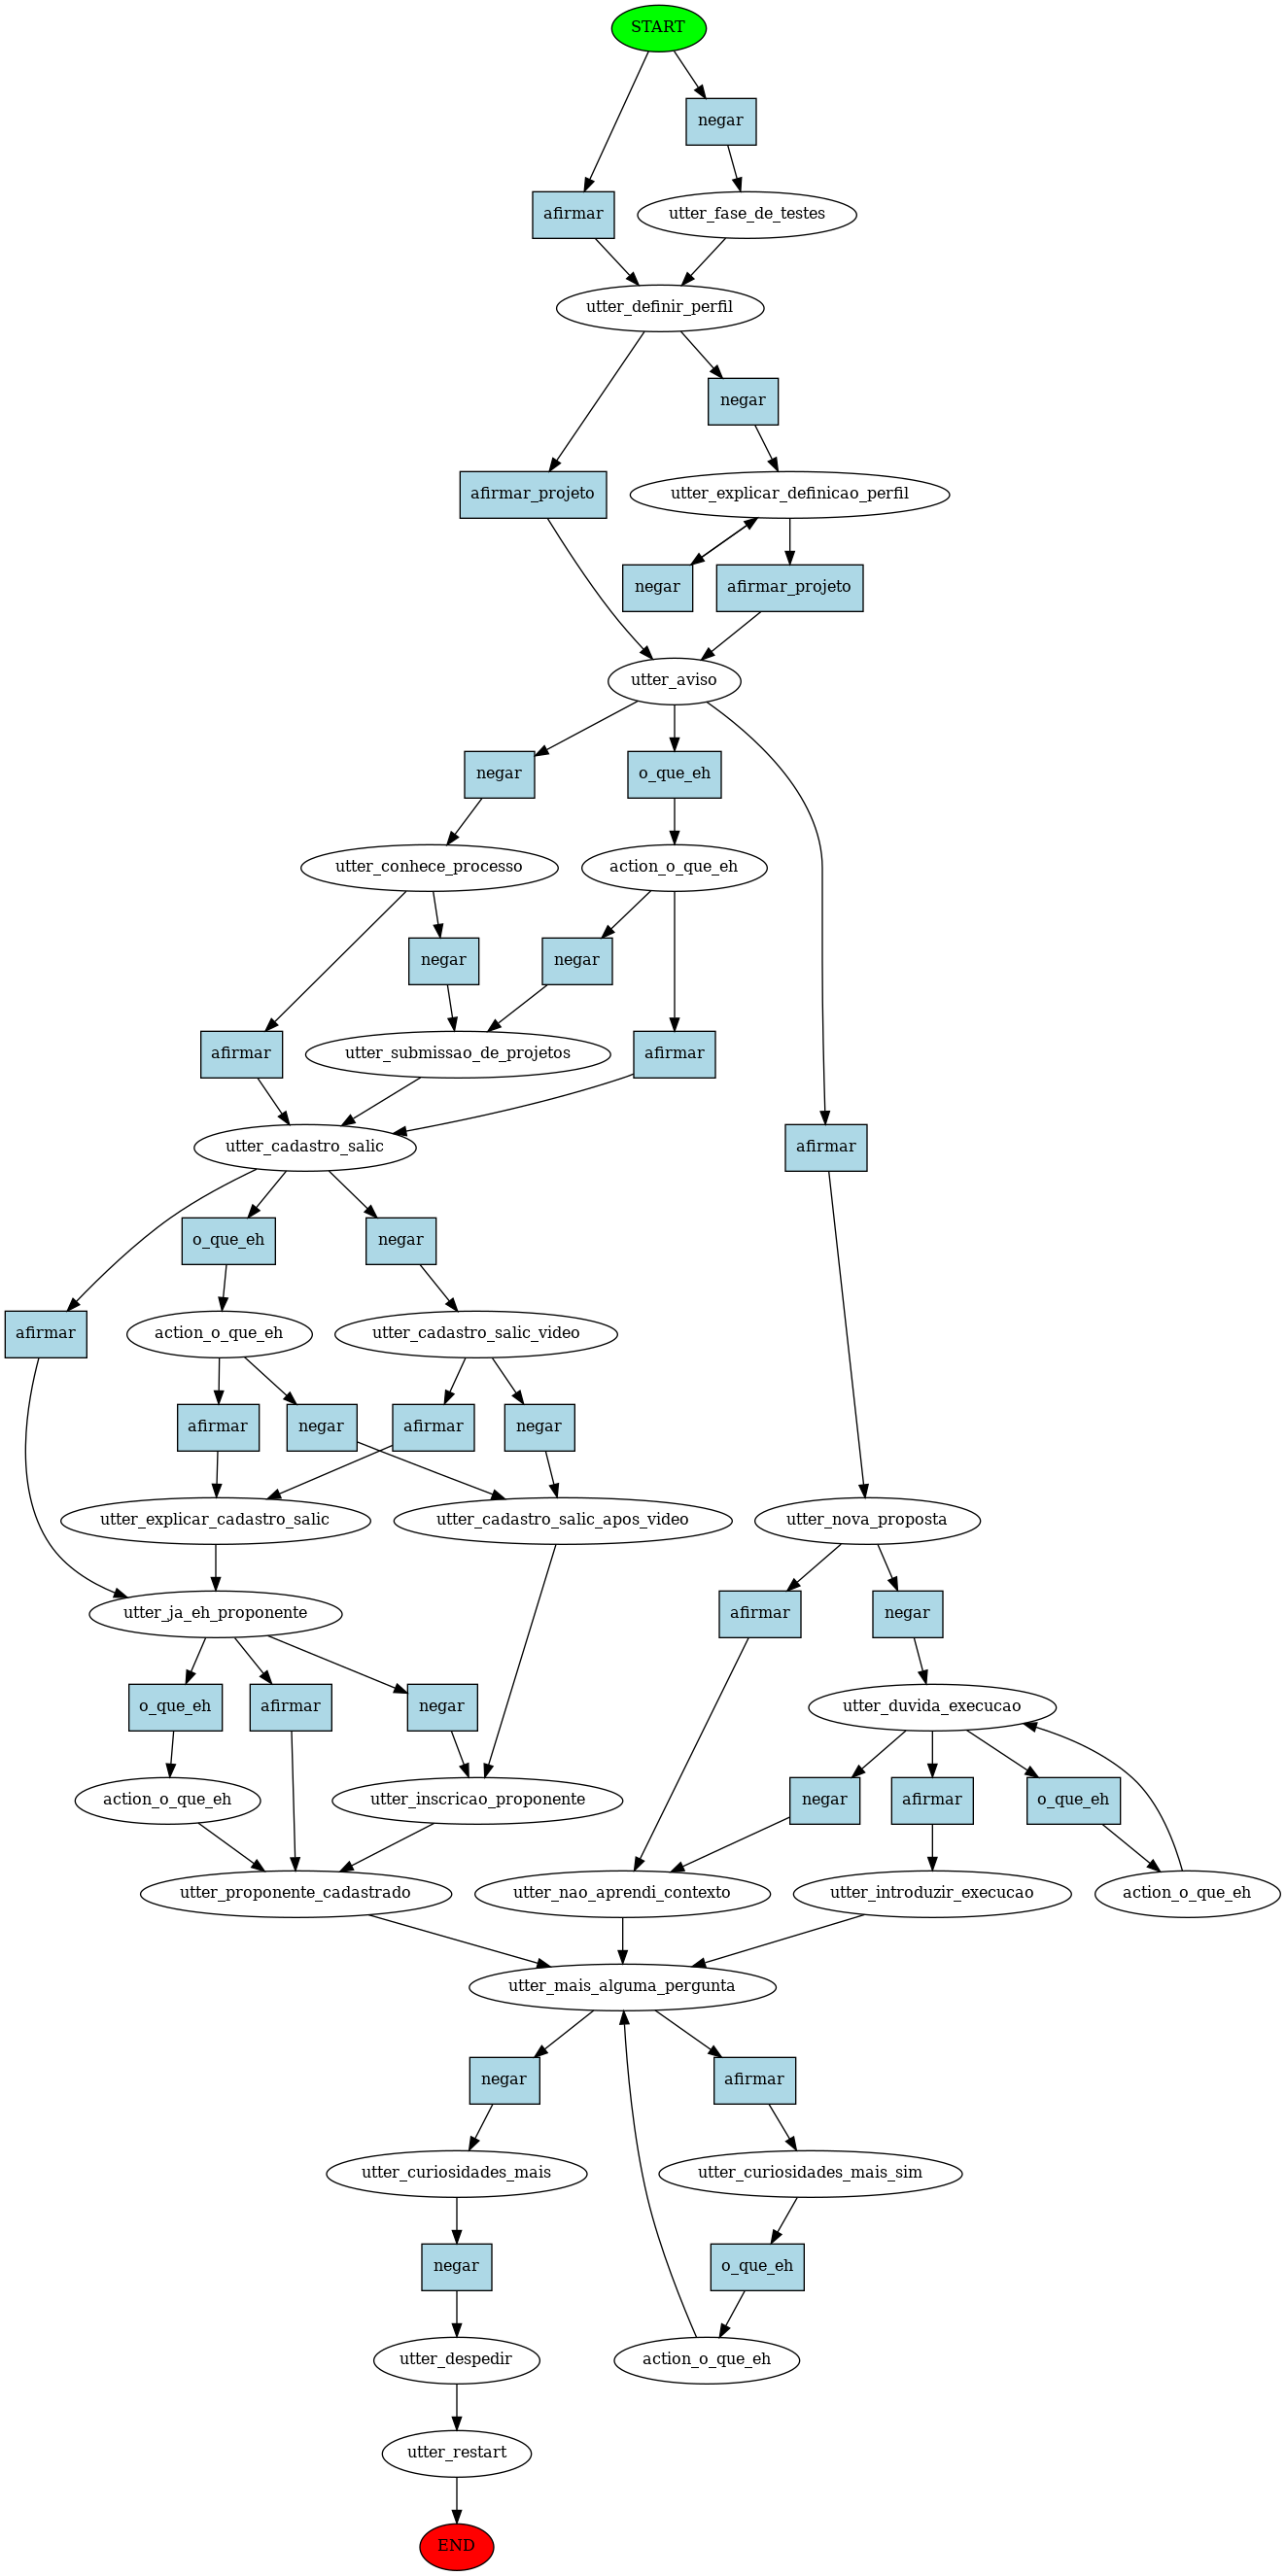

In [8]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('./domain.yml')
agent.visualize("./stories/fluxo.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

### Treinando o modelo de diálogo

`Para verificar possíveis melhorias no comportamento do bot mude a célula a seguir`

**importante** após identifcar melhorias atualize o arquivo de treinho do bot `train.py`

In [9]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.6)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('./stories/fluxo.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=400
)

agent.persist('models/dialogue')

Using TensorFlow backend.
Processed Story Blocks: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s, # trackers=122]     
Processed actions: 220it [00:00, 545.59it/s, # examples=220]
INFO:rasa_core.policies.memoization:Memorized 220 unique action examples.
INFO:rasa_core.policies.keras_policy:Fitting model with 220 total samples and a validation split of 0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 5, 53)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                11008     
_________________________________________________________________
dense_1 (Dense)              (None, 38)                1254      
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 12,262
Trainable params: 12,262
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
220/220 [==============================] - 0s 2ms/step - loss: 3.6183 - acc: 0.0500
Epoch 2/400
220/220 [==============================] - 0s 115us/step - loss: 3.5492 - acc: 0.2227
Epoch 3/400
220/220 [==============================] - 0s 119us/step - loss:

220/220 [==============================] - 0s 149us/step - loss: 0.5257 - acc: 0.9227
Epoch 158/400
220/220 [==============================] - 0s 168us/step - loss: 0.5337 - acc: 0.9045
Epoch 159/400
220/220 [==============================] - 0s 143us/step - loss: 0.5753 - acc: 0.8773
Epoch 160/400
220/220 [==============================] - 0s 123us/step - loss: 0.5414 - acc: 0.8864
Epoch 161/400
220/220 [==============================] - 0s 133us/step - loss: 0.5582 - acc: 0.8955
Epoch 162/400
220/220 [==============================] - 0s 129us/step - loss: 0.5273 - acc: 0.9182
Epoch 163/400
220/220 [==============================] - 0s 140us/step - loss: 0.5721 - acc: 0.8955
Epoch 164/400
220/220 [==============================] - 0s 152us/step - loss: 0.5589 - acc: 0.8773
Epoch 165/400
220/220 [==============================] - 0s 154us/step - loss: 0.5164 - acc: 0.8864
Epoch 166/400
220/220 [==============================] - 0s 144us/step - loss: 0.4984 - acc: 0.9136
Epoch 167/400


220/220 [==============================] - 0s 176us/step - loss: 0.2601 - acc: 0.9636
Epoch 240/400
220/220 [==============================] - 0s 163us/step - loss: 0.2401 - acc: 0.9591
Epoch 241/400
220/220 [==============================] - 0s 151us/step - loss: 0.2852 - acc: 0.9409
Epoch 242/400
220/220 [==============================] - 0s 152us/step - loss: 0.2757 - acc: 0.9500
Epoch 243/400
220/220 [==============================] - 0s 145us/step - loss: 0.2286 - acc: 0.9727
Epoch 244/400
220/220 [==============================] - 0s 156us/step - loss: 0.2430 - acc: 0.9636
Epoch 245/400
220/220 [==============================] - 0s 143us/step - loss: 0.2487 - acc: 0.9591
Epoch 246/400
220/220 [==============================] - 0s 157us/step - loss: 0.2492 - acc: 0.9500
Epoch 247/400
220/220 [==============================] - 0s 164us/step - loss: 0.2329 - acc: 0.9682
Epoch 248/400
220/220 [==============================] - 0s 139us/step - loss: 0.2222 - acc: 0.9773
Epoch 249/400


220/220 [==============================] - 0s 152us/step - loss: 0.1431 - acc: 0.9727
Epoch 322/400
220/220 [==============================] - 0s 146us/step - loss: 0.1158 - acc: 0.9909
Epoch 323/400
220/220 [==============================] - 0s 150us/step - loss: 0.1263 - acc: 0.9864
Epoch 324/400
220/220 [==============================] - 0s 119us/step - loss: 0.1271 - acc: 0.9864
Epoch 325/400
220/220 [==============================] - 0s 150us/step - loss: 0.1227 - acc: 0.9818
Epoch 326/400
220/220 [==============================] - 0s 125us/step - loss: 0.1494 - acc: 0.9864
Epoch 327/400
220/220 [==============================] - 0s 140us/step - loss: 0.1395 - acc: 0.9773
Epoch 328/400
220/220 [==============================] - 0s 147us/step - loss: 0.1187 - acc: 0.9818
Epoch 329/400
220/220 [==============================] - 0s 146us/step - loss: 0.1345 - acc: 0.9727
Epoch 330/400
220/220 [==============================] - 0s 141us/step - loss: 0.1223 - acc: 0.9864
Epoch 331/400


INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Persisted model to '/home/arthur/Documents/lappis/bot/rasa-demo-pydata18/tais/models/dialogue'


### Inicializando bot completo (core+nlu)

In [13]:
from rasa_core.agent import Agent
agent = Agent.load('./models/dialogue/', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-pt'.


### Testando conversação

In [21]:
print("Converse com o bot, diga 'stop' para encerrar teste.")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


Converse com o bot, diga 'stop' para encerrar teste.
sim


Exception: Can not access action 'utter_unclear', as that name is not a registered action for this domain. Available actions are: 
	 - action_listen
	 - action_o_que_eh
	 - action_restart
	 - utter_aviso
	 - utter_cadastro_salic
	 - utter_cadastro_salic_apos_video
	 - utter_cadastro_salic_video
	 - utter_conhece_processo
	 - utter_cumprimentar
	 - utter_curiosidades_beneficios_incentivo_projetos_culturais
	 - utter_curiosidades_deducao_imposto_de_renda_incentivador
	 - utter_curiosidades_elegibilidade_de_empresa_para_beneficios
	 - utter_curiosidades_falar_sobre_projetos
	 - utter_curiosidades_indicacao
	 - utter_curiosidades_lei_rouanet_arrecadamento
	 - utter_curiosidades_lei_rouanet_denuncia
	 - utter_curiosidades_lei_rouanet_elegibilidade
	 - utter_curiosidades_mais
	 - utter_curiosidades_mais_nao
	 - utter_curiosidades_mais_sim
	 - utter_curiosidades_quantidade_projetos
	 - utter_curiosidades_receber_incetivo_de_parentes
	 - utter_default
	 - utter_definir_perfil
	 - utter_despedir
	 - utter_duvida_execucao
	 - utter_explicar_cadastro_salic
	 - utter_explicar_definicao_perfil
	 - utter_fase_de_testes
	 - utter_inscricao_proponente
	 - utter_introduzir_execucao
	 - utter_ja_eh_proponente
	 - utter_mais_alguma_pergunta
	 - utter_nao_aprendi_contexto
	 - utter_nova_proposta
	 - utter_proponente_cadastrado
	 - utter_restart
	 - utter_submissao_de_projetos

### Avaliação do modelo de diálogo (`stories`)

In [19]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories/fluxo.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")

Processed Story Blocks: 100%|██████████| 32/32 [00:00<00:00, 82.19it/s, # trackers=522] 
INFO:rasa_core.evaluate:Evaluating 1322 stories
Progress:
  0%|          | 0/1322 [00:00<?, ?it/s]


Exception: Can not access action 'utter_unclear', as that name is not a registered action for this domain. Available actions are: 
	 - action_listen
	 - action_o_que_eh
	 - action_restart
	 - utter_aviso
	 - utter_cadastro_salic
	 - utter_cadastro_salic_apos_video
	 - utter_cadastro_salic_video
	 - utter_conhece_processo
	 - utter_cumprimentar
	 - utter_curiosidades_beneficios_incentivo_projetos_culturais
	 - utter_curiosidades_deducao_imposto_de_renda_incentivador
	 - utter_curiosidades_elegibilidade_de_empresa_para_beneficios
	 - utter_curiosidades_falar_sobre_projetos
	 - utter_curiosidades_indicacao
	 - utter_curiosidades_lei_rouanet_arrecadamento
	 - utter_curiosidades_lei_rouanet_denuncia
	 - utter_curiosidades_lei_rouanet_elegibilidade
	 - utter_curiosidades_mais
	 - utter_curiosidades_mais_nao
	 - utter_curiosidades_mais_sim
	 - utter_curiosidades_quantidade_projetos
	 - utter_curiosidades_receber_incetivo_de_parentes
	 - utter_default
	 - utter_definir_perfil
	 - utter_despedir
	 - utter_duvida_execucao
	 - utter_explicar_cadastro_salic
	 - utter_explicar_definicao_perfil
	 - utter_fase_de_testes
	 - utter_inscricao_proponente
	 - utter_introduzir_execucao
	 - utter_ja_eh_proponente
	 - utter_mais_alguma_pergunta
	 - utter_nao_aprendi_contexto
	 - utter_nova_proposta
	 - utter_proponente_cadastrado
	 - utter_restart
	 - utter_submissao_de_projetos